In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

In [2]:
original = cv2.cvtColor(cv2.imread("data/moon/original/lunar_original.jpeg"), cv2.COLOR_BGR2RGB)
iron = cv2.cvtColor(cv2.imread("data/moon/iron/lunar_iron_processed.jpeg"), cv2.COLOR_BGR2RGB)
thorium = cv2.cvtColor(cv2.imread("data/moon/thorium/lunar_thorium_processed.jpeg"), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread("data/moon/mask/mask.jpeg"), cv2.COLOR_BGR2GRAY)
thor_mask = cv2.cvtColor(cv2.imread("data/moon/thorium/thorium_mask.jpeg"), cv2.COLOR_BGR2GRAY)

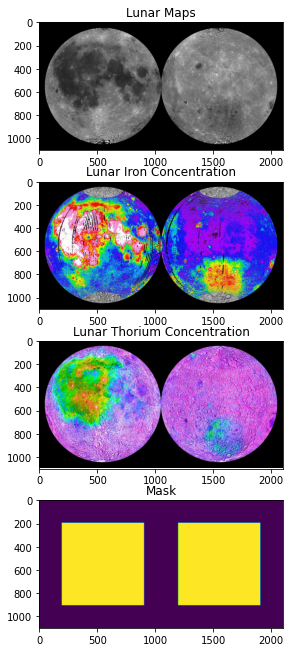

In [3]:
fig, ax = plt.subplots(4, 1, figsize = (18, 9))
plt.tight_layout()
ax[0].set_title("Lunar Maps")
ax[0].imshow(original)
ax[1].set_title("Lunar Iron Concentration")
ax[1].imshow(iron)
ax[2].set_title("Lunar Thorium Concentration")
ax[2].imshow(thorium)
ax[3].set_title("Mask")
ax[3].imshow(mask)
plt.show()

In [4]:
X_iron = np.array([
    [0, 0, 0],
    [80, 0, 97],
    [0, 40, 100],
    [0, 100, 100],
    [0, 98, 8],
    [100, 100, 0],
    [100, 60, 3],
    [100, 0, 0],
    [100, 100, 100]
]) / 100

# wt%
Y_iron = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16])

In [5]:
X_thorium = np.array([
    [50, 0, 50],
    [0, 0, 100],
    [0, 50, 100],
    [50, 100, 0],
    [100, 100, 0],
    [100, 50, 0],
    [100, 0, 0],
    [100, 100, 100]
]) / 100

# ppm
Y_thorium = np.array([1, 2, 4, 6, 8, 10, 12, 14])

In [6]:
W_iron = np.linalg.pinv(X_iron) @ Y_iron

In [7]:
lunar_iron = np.einsum("ijk,k->ij", iron/255, W_iron)

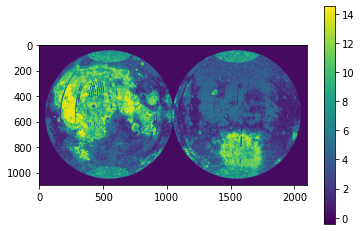

In [8]:
plt.imshow(lunar_iron)
plt.colorbar()
plt.show()

In [9]:
W_thorium = np.linalg.pinv(X_thorium) @ Y_thorium

In [10]:
lunar_thor_0 = np.einsum("ijk,k->ij", thorium/255, W_thorium)
lunar_thor_1 = np.einsum("ijk,k->ij", (thorium - original)/255, W_thorium)

In [11]:
lunar_thor = thor_mask.astype(np.float32)/255 * lunar_thor_0 /2 + lunar_thor_1

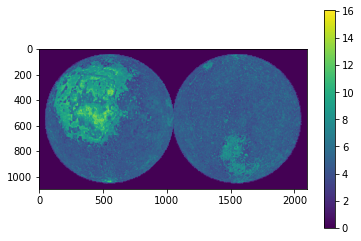

In [12]:
plt.imshow(lunar_thor)
plt.colorbar()
plt.show()

## Process lunar images

In [13]:
mask = mask/255

In [14]:
original_masked = np.einsum("ijk,ij->ijk", original, mask)
iron_masked = np.einsum("ij,ij->ij", lunar_iron, mask)
thor_masked = np.einsum("ij,ij->ij", lunar_thor, mask)

In [15]:
mx, my = np.where(mask!=0)

In [16]:
X, Y = [], []

size = 50
for i in range(original_masked.shape[0]//size-1):
    for j in range(original_masked.shape[1]//size-1):
        if (i*size in mx and j*size in my) and (i*size+size in mx and j*size+size in my):
            y = [
                iron_masked[i*size:i*size+size, i*size:j*size+size].mean(),
                thor_masked[i*size:i*size+size, i*size:j*size+size].mean()
            ]
            x = original_masked[i*size:i*size+size, j*size:j*size+size]
            if y[0] > 0 and y[1] > 0:
                X.append(x)
                Y.append(y)

/var/folders/py/04d4d7yn36qfx1_5cmmn5t8c0000gn/T/ipykernel_13453/3340641917.py:8: RuntimeWarning: Mean of empty slice.
  iron_masked[i*size:i*size+size, i*size:j*size+size].mean(),
/Users/casssheng/miniforge3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/py/04d4d7yn36qfx1_5cmmn5t8c0000gn/T/ipykernel_13453/3340641917.py:9: RuntimeWarning: Mean of empty slice.
  thor_masked[i*size:i*size+size, i*size:j*size+size].mean()


In [17]:
X_aug, Y_aug = [], []

for x, y in zip(X, Y):
    X_aug.append(
        cv2.flip(x, 0)
    )
    X_aug.append(
        cv2.flip(x, 1)
    )
    X_aug.append(
        cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE)
    )
    X_aug.append(
        cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE)
    )
    X_aug.append(
        cv2.rotate(x, cv2.ROTATE_180)
    )
    for i in range(5):
        Y_aug.append(y)

In [18]:
X_aug, Y_aug = np.array(X_aug)/255, np.array(Y_aug)

In [19]:
Xt, Yt = torch.from_numpy(X_aug).float().permute(0, 3, 1, 2), torch.from_numpy(Y_aug).float()

## Training CNN

In [20]:
class Net(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        
        self.c = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.ReLU(),
        )
        
        self.f1 = nn.Sequential(
            nn.Linear(256, 32),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        
        self.f2 = nn.Sequential(
            nn.Linear(256, 32),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        z = self.c(x)
        z = z.mean(dim=[-1,-2])
        h1 = self.f1(z)
        h2 = self.f2(z)
        return torch.cat([h1, h2], 1)

In [28]:
net = Net()

optim = opt.Adam(net.parameters(), lr=3e-4, weight_decay=0.01)
mse = nn.MSELoss()

In [29]:
Xt, Yt = shuffle(Xt, Yt)

In [30]:
n = int(0.8 * len(Xt))

X_train, Y_train = Xt[:n], Yt[:n]
X_test, Y_test = Xt[n:], Yt[n:]

In [31]:
batch_size = 32
epochs = 200

loss_hist = []
val_loss_hist = []

for e in range(epochs):
    print(f"Epoch {e+1}/{epochs}:")
    
    X_train, Y_train = shuffle(X_train, Y_train)
    X_test, Y_test = shuffle(X_test, Y_test)
    
    running_loss = []
    net.train()
    for i in range(0, len(X_train), batch_size):
        xb, yb = X_train[i:i+batch_size], Y_train[i:i+batch_size]
        optim.zero_grad(set_to_none=True)
        pred = net(xb)
        loss = mse(pred, yb)
        loss.backward()
        optim.step()
        
        running_loss.append(loss.item())
        
        print(f"Loss: {np.round(np.mean(running_loss), 5)}", end = "\r", flush = True)
    
    loss_hist.append(np.mean(running_loss))
    
    net.eval()
    with torch.no_grad():
        xtb, ytb = X_test[0:batch_size], Y_test[0:batch_size]
        ptb = net(xtb)
        lst = mse(ptb, ytb)
        
    val_loss_hist.append(lst.item())
    
    print(f"Epoch {e+1}/{epochs} completed, mean loss = {np.round(loss_hist[-1], 5)}, val loss = {np.round(val_loss_hist[-1], 5)}")

Epoch 1/200:
Epoch 1/200 completed, mean loss = 21.32032, val loss = 25.52497
Epoch 2/200:
Epoch 2/200 completed, mean loss = 8.81066, val loss = 13.46125
Epoch 3/200:
Epoch 3/200 completed, mean loss = 5.25564, val loss = 13.02631
Epoch 4/200:
Epoch 4/200 completed, mean loss = 4.7318, val loss = 10.88112
Epoch 5/200:
Epoch 5/200 completed, mean loss = 4.40477, val loss = 6.62818
Epoch 6/200:
Epoch 6/200 completed, mean loss = 4.06234, val loss = 7.00713
Epoch 7/200:
Epoch 7/200 completed, mean loss = 4.34852, val loss = 6.34713
Epoch 8/200:
Epoch 8/200 completed, mean loss = 3.85036, val loss = 8.63808
Epoch 9/200:
Epoch 9/200 completed, mean loss = 3.97622, val loss = 6.06924
Epoch 10/200:
Epoch 10/200 completed, mean loss = 3.89919, val loss = 4.86431
Epoch 11/200:
Epoch 11/200 completed, mean loss = 4.02268, val loss = 4.73676
Epoch 12/200:
Epoch 12/200 completed, mean loss = 4.02401, val loss = 4.64655
Epoch 13/200:
Epoch 13/200 completed, mean loss = 4.21846, val loss = 5.18364


Epoch 106/200 completed, mean loss = 2.65946, val loss = 2.91226
Epoch 107/200:
Epoch 107/200 completed, mean loss = 2.41855, val loss = 2.96964
Epoch 108/200:
Epoch 108/200 completed, mean loss = 2.58733, val loss = 2.15157
Epoch 109/200:
Epoch 109/200 completed, mean loss = 2.55559, val loss = 5.06852
Epoch 110/200:
Epoch 110/200 completed, mean loss = 2.58758, val loss = 2.42164
Epoch 111/200:
Epoch 111/200 completed, mean loss = 2.62204, val loss = 3.30175
Epoch 112/200:
Epoch 112/200 completed, mean loss = 2.57659, val loss = 1.2323
Epoch 113/200:
Epoch 113/200 completed, mean loss = 2.67831, val loss = 3.30956
Epoch 114/200:
Epoch 114/200 completed, mean loss = 2.59722, val loss = 2.68917
Epoch 115/200:
Epoch 115/200 completed, mean loss = 2.58268, val loss = 2.27517
Epoch 116/200:
Epoch 116/200 completed, mean loss = 2.47817, val loss = 3.33241
Epoch 117/200:
Epoch 117/200 completed, mean loss = 2.76218, val loss = 3.17632
Epoch 118/200:
Epoch 118/200 completed, mean loss = 2.47

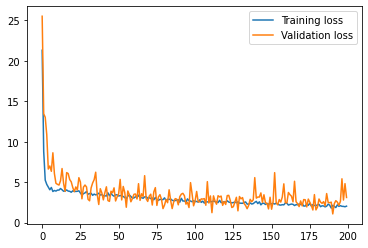

In [32]:
plt.plot(loss_hist)
plt.plot(val_loss_hist)
plt.legend(["Training loss", "Validation loss"])
plt.show()

In [33]:
net.eval()
with torch.no_grad():
    preds = net(X_test)

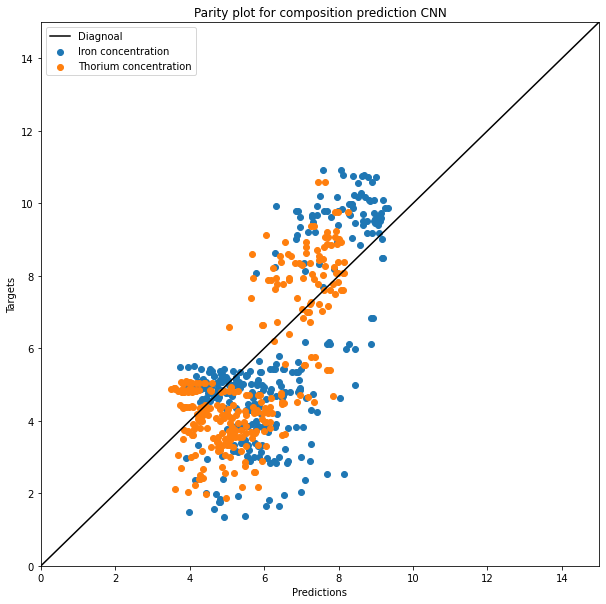

In [34]:
plt.figure(figsize = (10, 10))
plt.title("Parity plot for composition prediction CNN")
plt.plot(np.linspace(0, 15), np.linspace(0, 15), "k")
plt.scatter(preds.T[0], Y_test.T[0])
plt.scatter(preds.T[1], Y_test.T[1])
plt.legend(["Diagnoal", "Iron concentration", "Thorium concentration"])
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.show()

In [49]:
torch.save(net.state_dict(), "models/cnn.pth")

## Real image validation

In [45]:
test_inp1 = cv2.cvtColor(cv2.imread("data/moon/val_1.png"), cv2.COLOR_BGR2RGB)
test_inp2 = cv2.cvtColor(cv2.imread("data/moon/val_2.png"), cv2.COLOR_BGR2RGB)

test_inp_1 = torch.from_numpy(test_inp1/255).float().unsqueeze(0).permute(0, 3, 1, 2)
test_inp_2 = torch.from_numpy(test_inp2/255).float().unsqueeze(0).permute(0, 3, 1, 2)

In [46]:
net.eval()
with torch.no_grad():
    prediction1 = net(test_inp_1)
    prediction2 = net(test_inp_2)

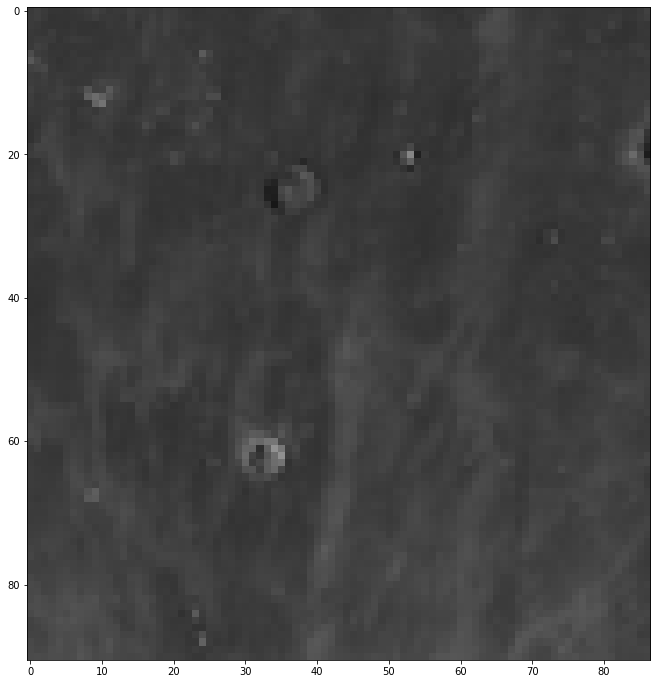

tensor([[8.2250, 7.0910]])


In [47]:
plt.figure(figsize = (12, 12))
plt.imshow(test_inp1)
plt.show()

print(prediction1)

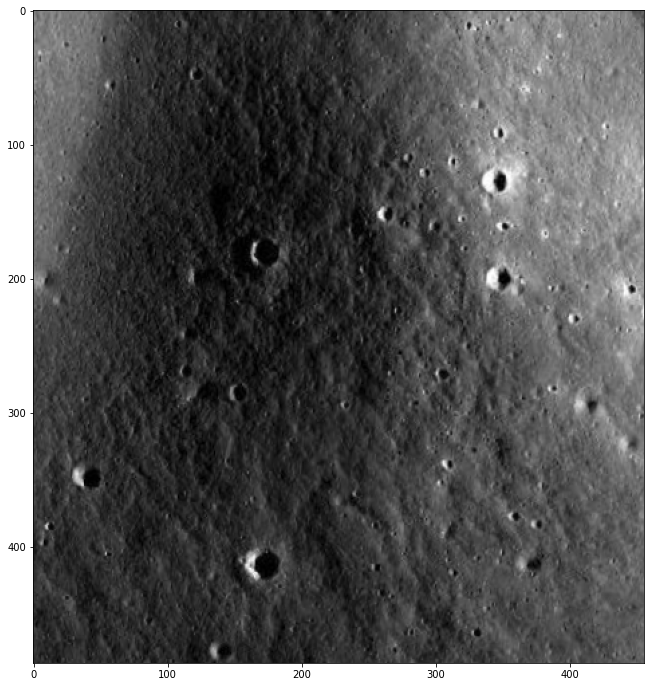

tensor([[5.4223, 4.5998]])


In [48]:
plt.figure(figsize = (12, 12))
plt.imshow(test_inp2)
plt.show()

print(prediction2)